In [ ]:
#Risk Type → multi-label classifier (extension: One-vs-Rest Logistic Regression or multi-task neural net with sigmoid outputs).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, confusion_matrix


In [29]:
#load data
data =  pd.read_csv("merged_numeric_data_ready_for_prediction.csv")  

# === STEP 1: Detect ticker leakage ===
ticker_risks = data.groupby('ticker')['Risk Level'].nunique().reset_index()
ticker_risks.columns = ['ticker', 'unique_risk_levels']
multi_risk_tickers = ticker_risks.loc[ticker_risks['unique_risk_levels'] > 1, 'ticker']

if len(multi_risk_tickers) == 0:
    print("All tickers have only one Risk Level — removing ticker to avoid leakage.")
    filtered_data = data.copy()
    use_ticker = False
else:
    filtered_data = data[data['ticker'].isin(multi_risk_tickers)]
    use_ticker = True

All tickers have only one Risk Level — removing ticker to avoid leakage.


In [30]:
# === STEP 2: Encode multi-label target ===
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(filtered_data['Risk Level'])
print("Classes:", mlb.classes_)


Classes: ['H' 'L' 'M' 'd' 'e' 'g' 'h' 'i' 'm' 'o' 'u' 'w']


In [31]:
# === STEP 3: Prepare features ===
if use_ticker:
    X = filtered_data[['ticker', 'year', 'year_scaled']]
    categorical_features = ['ticker']
else:
    X = filtered_data[['year', 'year_scaled']]
    categorical_features = []

numeric_features = ['year', 'year_scaled']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [32]:
# === STEP 4: Split data (group-aware to avoid leakage) ===
if use_ticker:
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
    for train_idx, test_idx in splitter.split(X, y, groups=filtered_data['ticker']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )

In [33]:
# === STEP 5: Define models ===
models = {
    "OvR Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "Multi-task Neural Network": MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42))
}


===== OvR Logistic Regression =====
Hamming Loss: 0.12950450450450451
              precision    recall  f1-score   support

           H       1.00      1.00      1.00       138
           L       1.00      1.00      1.00       378
           M       0.67      0.64      0.66       446
           d       0.67      0.64      0.66       446
           e       0.67      0.64      0.66       446
           g       1.00      1.00      1.00       138
           h       1.00      1.00      1.00       138
           i       1.00      1.00      1.00       584
           m       0.67      0.64      0.66       446
           o       1.00      1.00      1.00       378
           u       0.67      0.64      0.66       446
           w       1.00      1.00      1.00       378

   micro avg       0.84      0.82      0.83      4362
   macro avg       0.86      0.85      0.86      4362
weighted avg       0.83      0.82      0.82      4362
 samples avg       0.92      0.86      0.83      4362



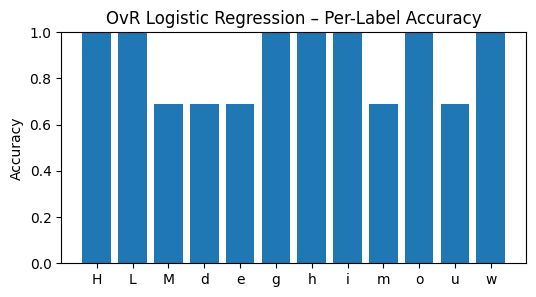


===== Multi-task Neural Network =====
Hamming Loss: 0.0
              precision    recall  f1-score   support

           H       1.00      1.00      1.00       138
           L       1.00      1.00      1.00       378
           M       1.00      1.00      1.00       446
           d       1.00      1.00      1.00       446
           e       1.00      1.00      1.00       446
           g       1.00      1.00      1.00       138
           h       1.00      1.00      1.00       138
           i       1.00      1.00      1.00       584
           m       1.00      1.00      1.00       446
           o       1.00      1.00      1.00       378
           u       1.00      1.00      1.00       446
           w       1.00      1.00      1.00       378

   micro avg       1.00      1.00      1.00      4362
   macro avg       1.00      1.00      1.00      4362
weighted avg       1.00      1.00      1.00      4362
 samples avg       1.00      1.00      1.00      4362



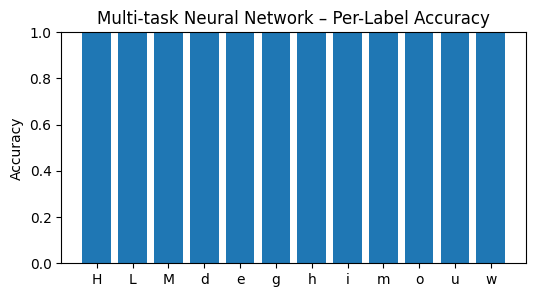

In [34]:
# === STEP 6: Train, evaluate, and plot per-label accuracy ===
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Hamming Loss
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    
    # Classification report
    print(classification_report(y_test, y_pred, target_names=mlb.classes_))

    # Per-label accuracy
    per_label_acc = np.mean(y_pred == y_test, axis=0)
    plt.figure(figsize=(6,3))
    plt.bar(mlb.classes_, per_label_acc)
    plt.title(f"{name} – Per-Label Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.show()
